In [1]:
# Preamble
import concurrent.futures
import matplotlib
import matplotlib.pyplot as plt
# import pprint
import random
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed, wait
%matplotlib inline
# Slightly larger-than-normal figures
matplotlib.rcParams['figure.figsize'] = (8, 5)

from helpers import fetch_datum, store_output, n_fibonacci, digits_fibonacci
# fetch_datum = fake_io
# store_output = fake_io

random.seed(42)
# print = pprint.pprint

Visualizing `concurrent.futures`
===================

This notebook shows how the `concurrent.future` module can be used to speed up the running time of a data processing task that involves an arbitrary number of similar sub-tasks.

Our 'data processing' task consists in calculating the nth Fibonacci number $F_n$, given an input $n$.

The Fibonacci sequence is defined as follows:

$$
F_n = F_{n-1} + F_{n-2}
$$
with seed values $F_0 = 0$ and $F_1 = 1$ [see more].

[see more]: https://en.wikipedia.org/wiki/Fibonacci_number

In [2]:
fibonacci_sequence = [
    n_fibonacci(n) for n in range(10)
]
fibonacci_sequence

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

Processing is quite fast for small integers:

In [3]:
%time n_fibonacci(10)
# random.random()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


55

and it gets slower for larger numbers:

In [4]:
%time n_fibonacci(20000)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.31 ms


2531162323732361242240155003520607291766356485802485278951929841991312781760541315230153423463758831637443488219211037689033673531462742885329724071555187618026931630449193158922771331642302030331971098689235780843478258502779200293635651897483309686042860996364443514558772156043691404155819572984971754278513112487985892718229593329483578531419148805380281624260900362993556916638613939977074685016188258584312329139526393558096840812970422952418558991855772306882442574855589237165219912238201311184749075137322987656049866305366913734924425822681338966507463855180236283582409861199212323835947891143765414913345008456022009455704210891637791911265475167769704477334859109822590053774932978465651023851447920601310106288957894301592502061560528131203072778677491443420921822590709910448617329156135355464620891788459566081572824889514296350670950824208245170667601726417091127999999941149913010424532046881958285409468463211897582215075436515584016297874572183907949257286261608612401379639484713

The last output shows how large the 20000th Fibonacci number actually is.  
What if we just checked the number of digits in the nth Fibonacci number?

In [5]:
%time digits_fibonacci(int(2E4))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.49 ms


4180

So the 20000th Fibonacci number has 4180 digits (This is done purely to avoid output flooding) :-D

### Define a list of inputs

Nothing fancy here.
This is a uniform distribution of numbers in the range $200000 \pm 50000$.

In [6]:
input_numbers = [
    int(2E5) + random.randint(-1E5, 1E5) // 2 for __ in range(16)
]
print(input_numbers)

[233810, 164592, 153278, 247196, 186048, 182098, 179256, 168289, 246530, 163434, 238696, 247080, 221482, 161395, 227397, 205302]


Let's see how they look:

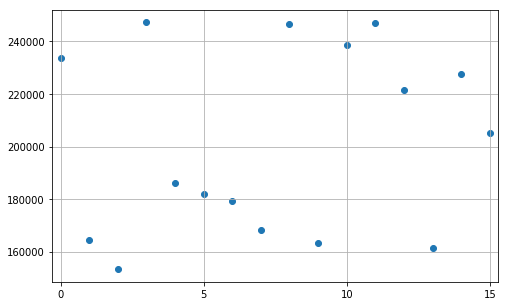

In [7]:
plt.scatter(range(len(input_numbers)), input_numbers)
plt.xlim(-0.3, 15.3)
plt.xticks([0, 5, 10, 15])
plt.grid();

One should factor in some additional time for read/write from/to disk/API, or the I/O of choice:

In [8]:
%%time
data_in = fetch_datum(int(2e4)) # e.g read data from disk/API
n_digits = digits_fibonacci(data_in)
print(store_output(n_digits)) # e.g. write data to disk/API

4180
CPU times: user 40 ms, sys: 104 ms, total: 144 ms
Wall time: 452 ms


Let's see how long the whole process takes:

In [9]:
%%time
for n in input_numbers:
    fetch_datum(n) # e.g. read data from disk/API
    n_digits = digits_fibonacci(n)
    print(store_output(n_digits), end=" ") # e.g. write data to disk/API
print()

48864 34398 32033 51661 38882 38056 37462 35170 51522 34156 49885 51637 46287 33730 47523 42906 
CPU times: user 8.12 s, sys: 24 ms, total: 8.14 s
Wall time: 17.3 s


Let's take a closer look, using checkpoints at each step:

In [10]:
%%time
start = time.time()
seq_checkpoints = []
seq_checkpoints.append(time.time() - start)
for n in input_numbers:
    fetch_datum(n) # e.g read data from disk/API
    seq_checkpoints.append(time.time() - start)
    n_digits = digits_fibonacci(n)
    seq_checkpoints.append(time.time() - start)
    print(store_output(n_digits), end=" ") # e.g. write data to disk/API
    seq_checkpoints.append(time.time() - start)
print()

48864 34398 32033 51661 38882 38056 37462 35170 51522 34156 49885 51637 46287 33730 47523 42906 
CPU times: user 7.65 s, sys: 4 ms, total: 7.65 s
Wall time: 17.5 s


We can now visualize the time taken by each task, in sequential order.

(0, 4)

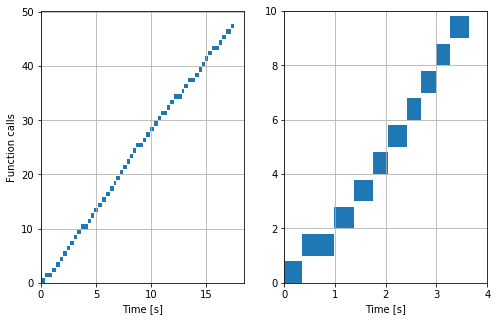

In [11]:
seq_widths = [
    x - y for x, y in zip(seq_checkpoints[1:], seq_checkpoints[:-1])
]
# plt.figure(figsize=(12,8))
fig, axes = plt.subplots(1, 2)
# plt.title("Functions time usage")
for ax in axes:
    ax.barh(range(len(seq_checkpoints[1:])), seq_widths, left=seq_checkpoints[:-1], align='edge')
    ax.set_ylim((0, None))
    ax.set_xlabel("Time [s]")
#     plt.xlabel("Time [s]")
    ax.grid()
axes[0].set_ylabel("Function calls")
axes[1].set_ylim((0,10))
axes[1].set_xlim((0,4))
# plt.plot(seq_checkpoints[::2], 'o-')

On the y axis are consecutive function calls (i.e. *tasks*, be them I/O or CPU).
The x axis displays cumulative time.
The plot on the right is just a magnification of the left.

### CPU vs I/O time usage analysis

We can group our processing steps into "pure computation" and read/write tasks.
It will soon become apparent why this is interesting:

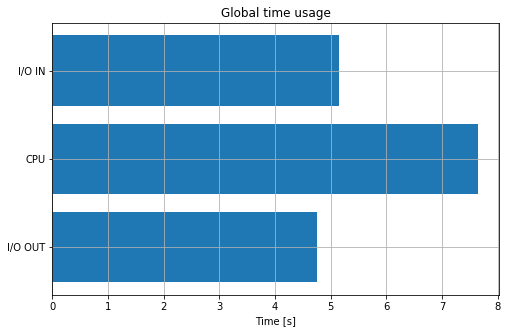

In [12]:
io_in = sum(seq_widths[::3])
cpu = sum(seq_widths[1::3])
io_out = sum(seq_widths[2::3])

ax = plt.barh(range(3), [io_out, cpu, io_in])
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

About 10 seconds are spent in I/O operations and 7 seconds in CPU operations.

## Concurrency in Python

Using the `concurrent.futures` module, it is quite straightforward to leverage concurrency.
The module provides an easy-to-use API for using multiple threads or processes in Python.

The main construct of the module is the *Executor* class, which interfaces to a pool
of workers (threads or processes).
The executor can receive work (our functions), distribute it to the pool, and give back results.

The number of workers is automatically determined, but can be specified
using the `max_workers` keyword argument.

An *Executor* implements two main methods:

- **map()**: equivalent to the standard *map()* function, only allowing asynchronous calls.
  Returns an iterator object.
- **submit()**: This methods accepts a callable (e.g. a function) and its arguments, and schedules it
  to be executed by the pool of workers.
  The method returns a *Future* object, representing the execution of the callable.
  This object has a *result()* method, that returns the value returned by the call,
  once the execution is done.


See the full documentation [here](https://docs.python.org/3/library/concurrent.futures.html).

<!--The easiest entity to use are threads, so let's try that first.-->

The simplest way to leverage `concurrent.futures` is arguably using the *map* method.
This, however, requires a slight rewriting of the code.
In practice, whenever there's a loop over an iterable, *map* should be used instead.

Here's the rewritten sequential version:

In [13]:
start = time.time()

data_in = list(map(fetch_datum, input_numbers)) # e.g read data from disk/API

processed_data = list(map(digits_fibonacci, data_in))

data_out = list(map(store_output, processed_data)) # e.g. write data to disk/API
print(data_out)

print("{} secs".format(time.time() - start))

[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
17.968209505081177 secs


There might be a slight speedup, due to *map* being more efficient than *for* loops.

### Multithreading

Once the code is rewritten this way (this is a more [functional](https://en.wikipedia.org/wiki/Functional_programming) style BTW)
it's straightforward to write the concurrent version.  
The only difference are:
1. in the use of the executor within a context manager
2. the *map* executor method instead of the built-in python *map*.

In [14]:
start = time.time()
tp_chkpts = [] # Checkpoints list
tp_chkpts.append(time.time() - start)  # Checkpoint

with ThreadPoolExecutor() as tp:
    data_in = list(tp.map(fetch_datum, input_numbers)) # e.g read data from disk/API
    check = time.time() - start
    print(check)
    tp_chkpts.append(check)  # Checkpoint
    
    processed_data = list(tp.map(digits_fibonacci, data_in))
    check = time.time() - start
    print(check)
    tp_chkpts.append(check)  # Checkpoint
    
    data_out = tp.map(store_output, processed_data) # e.g. write data to disk/API
print(list(data_out))
tp_chkpts.append(time.time() - start)  # Checkpoint

print("{} secs".format(time.time() - start))  # Total time

0.39707207679748535
12.314069986343384
[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
12.714184522628784 secs


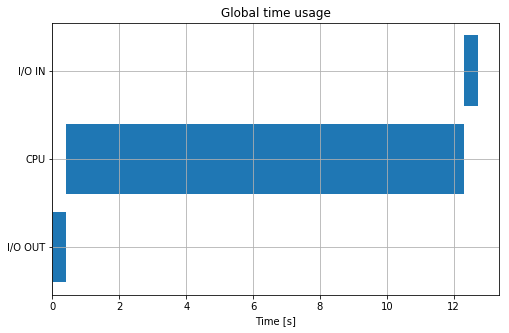

In [15]:
tp_widths = [
    x - y for x, y in zip(tp_chkpts[1:], tp_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(tp_chkpts[1:])), tp_widths, left=tp_chkpts[:-1])
# plt.plot(tp_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")

# plt.barh(range(3), [io_out, cpu, io_in])
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

There may or may not be some sort of improvement in this case.
One can see massive improvement with the I/O operations, but
the same cannot be said for the CPU-bound work.

Any idea why?

### Multiprocessing

To switch from threads to processes is just a matter of replacing
`ThreadPoolExecutor` with `ProcessPoolExecutor`.

In [16]:
start = time.time()
pp_chkpts = []
pp_chkpts.append(time.time() - start)
with ProcessPoolExecutor() as pp:
    data_in = list(pp.map(fetch_datum, input_numbers)) # e.g read data from disk/API
    pp_chkpts.append(time.time() - start)
    processed_data = list(pp.map(digits_fibonacci, data_in))
    pp_chkpts.append(time.time() - start)
    data_out = pp.map(store_output, processed_data) # e.g. write data to disk/API
    print(list(data_out))
    pp_chkpts.append(time.time() - start)
print("{} secs".format(time.time() - start))

[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
5.026548862457275 secs


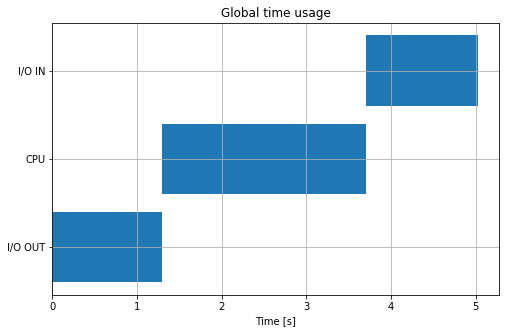

In [17]:
pp_widths = [
    x - y for x, y in zip(pp_chkpts[1:], pp_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(pp_chkpts[1:])), pp_widths, left=pp_chkpts[:-1])
# plt.plot(pp_chkpts[::2], 'o-')
# plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
# plt.grid()
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

Now we are talking.
Multiprocessing gives a 4x speedup (on a 4-core machine).

### Mixin' it up

It is possible to use both thread and process pools
in the same program and get the best of both worlds:

In [18]:
%%time
start = time.time()
pt_chkpts = []
pt_chkpts.append(time.time() - start)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        data_in = list(tp.map(fetch_datum, input_numbers))
        pt_chkpts.append(time.time() - start)
        processed_data = list(pp.map(digits_fibonacci, data_in))
        pt_chkpts.append(time.time() - start)
        data_out = list(tp.map(store_output, processed_data))
        print(data_out)
        pt_chkpts.append(time.time() - start)
#         print(list(tp.map(fake_io, processed_data)))

[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
CPU times: user 56 ms, sys: 88 ms, total: 144 ms
Wall time: 3.26 s


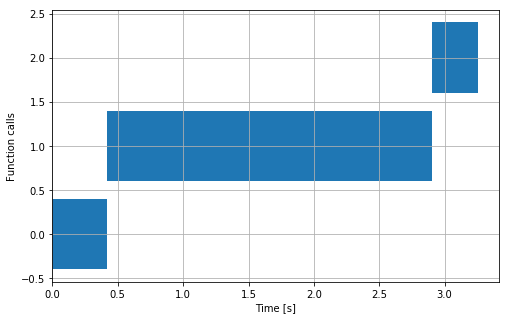

In [19]:
pt_widths = [
    x - y for x, y in zip(pt_chkpts[1:], pt_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(pt_chkpts[1:])), pt_widths, left=pt_chkpts[:-1])
# plt.plot(pt_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

Using both threads and processes yields a 6x improvement
over purely sequential code.
This can be achieved by assigning I/O bound work to the pool of threads
and CPU-bound work to the pool of processes.

### Using futures

Submitting work to the pool and using its scheduling capability
with the *Future* object can lead to very efficient code.
Here's an example using only threads.

In [20]:
%%time
start = time.time()
tt_chkpts = []
tt_chkpts.append(time.time() - start)
with ThreadPoolExecutor() as tp:
        data_in = [
            tp.submit(fetch_datum, i) for i in input_numbers
        ]
        # This slows down things but it's necessary for recording time
        wait(data_in)
        tt_chkpts.append(time.time() - start)
        # This part is purely sequential
        processed_data = [
            digits_fibonacci(f.result()) for f in as_completed(data_in)
        ]
        tt_chkpts.append(time.time() - start)
        data_out = [
            tp.submit(store_output, d) for d in processed_data
        ]
        print([
            f.result() for f in as_completed(data_out)
        ])
        tt_chkpts.append(time.time() - start)
#         print(list(tp.map(fake_io, processed_data)))

[46287, 38882, 51522, 33730, 47523, 51661, 34156, 34398, 37462, 51637, 48864, 49885, 42906, 38056, 35170, 32033]
CPU times: user 7.5 s, sys: 56 ms, total: 7.56 s
Wall time: 8.25 s


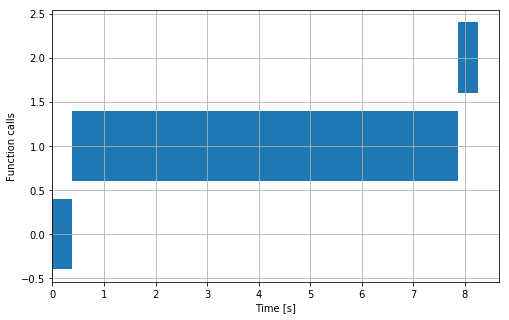

In [21]:
tt_widths = [
    x - y for x, y in zip(tt_chkpts[1:], tt_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(tt_chkpts[1:])), tt_widths, left=tt_chkpts[:-1])
# plt.plot(tt_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

In this case it's apparent how the I/O tasks are extremely optimized by
the use of a pool of threads.
The CPU-bound work is running sequentially.

### The full package (threads, processes, futures)

Fully asynchronous execution is achieved when threads
and processes are used in combination with futures.

In [22]:
%%time
start = time.time()
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        data_in = [
            tp.submit(fetch_datum, i) for i in input_numbers
        ]

        processed_data = [
            pp.submit(digits_fibonacci, f.result()) for f in as_completed(data_in)
        ]

        data_out = [
            tp.submit(store_output, d.result()) for d in processed_data
        ]
        
        print([
            f.result() for f in as_completed(data_out)
        ])
        
        full_async = time.time() - start

[47523, 42906, 32033, 34156, 35170, 37462, 38056, 48864, 33730, 46287, 34398, 51637, 49885, 38882, 51661, 51522]
CPU times: user 44 ms, sys: 84 ms, total: 128 ms
Wall time: 2.82 s


This comes at a little cost though: there is no easy way to monitor
the duration of the different steps.
One can only measure the total time.

The benefit of this approach is also limited, and depends on the
nature of the problem at hand, while there is considerable
added complexity in the structure of the code.
For most basic applications, sticking to the *map* method may
be a simpler (hence better) solution.

## Summary

Let's summarize the performance of different configurations.

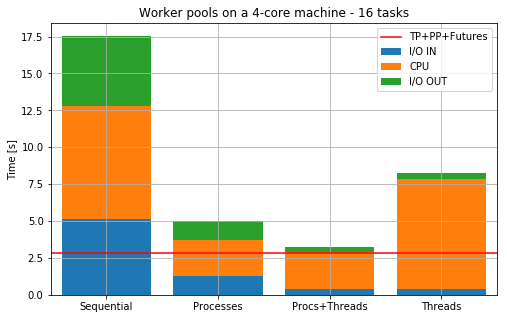

In [26]:
io_in, cpu, io_out = [], [], []
options = {
    "Sequential": seq_widths,
    "Processes": pp_widths,
    "Procs+Threads": pt_widths,
    "Threads": tt_widths
}

# plt.figure(figsize=(14,4))
for name, widths in options.items():
    io_in.append(
        sum(widths[::3])
    )
    cpu.append(
        sum(widths[1::3])
    )
    io_out.append(
        sum(widths[2::3])
    )
plt.bar(range(4), io_in, label="I/O IN")
plt.bar(range(4), cpu, bottom=io_in, label="CPU")
plt.bar(range(4), io_out, bottom=[a + b for a,b in zip(cpu, io_in)], label="I/O OUT")
plt.plot(range(-1, 6), 7*[full_async], label="TP+PP+Futures", c='red')
plt.xlim((-0.5, 3.5))
plt.xticks(range(4), (
    "Sequential",
    "Processes",
    "Procs+Threads",
    "Threads",
))
plt.ylabel("Time [s]")
plt.title("Worker pools on a 4-core machine - 16 tasks")
plt.grid()
plt.legend();
plt.savefig("./images/summary.png", dpi=200)

It's apparent how the combination of both multiple processes and threads delivers the best performance.
The pool of processes comes in second, while the pool of threads alone is third.

It's worth noting how second and third place would exchange places depending on the nature of the program.
In case of I/O-bound work, threads give usually the best performance,
while processes work best for CPU-bound work.

# Scaling with number of tasks

This is just a silly *divertissement* on how
many threads/processes one can spawn at once.

It's probably wrong on so many levels. :-D

CPU times: user 7.04 s, sys: 2.16 s, total: 9.2 s
Wall time: 26.2 s


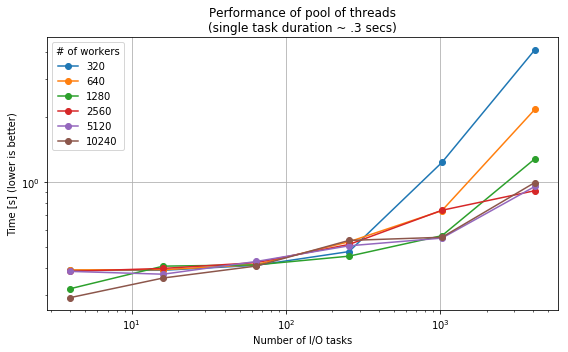

In [24]:
%%time
times = []
th_startups = []
task_numbers = [2**x for x in range(2, 13, 2)] 
workers_numbers = [5*2**x for x in range(6, 12)]
for n_workers in workers_numbers:
    startup_start = time.time()
    with ThreadPoolExecutor(n_workers) as tp:
        th_startups.append(time.time() - startup_start)
        for n_tasks in task_numbers:
            start = time.time()
            list(tp.map(fetch_datum, range(n_tasks)))
            times.append(time.time() - start)
    plt.plot(task_numbers, times, '-o', label=n_workers)
    times = []
plt.grid()
plt.legend(title="# of workers")
plt.title("Performance of pool of threads\n(single task duration ~ .3 secs)")
plt.ylabel("Time [s] (lower is better)")
plt.xlabel("Number of I/O tasks");
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig("images/threads.png", dpi=150);

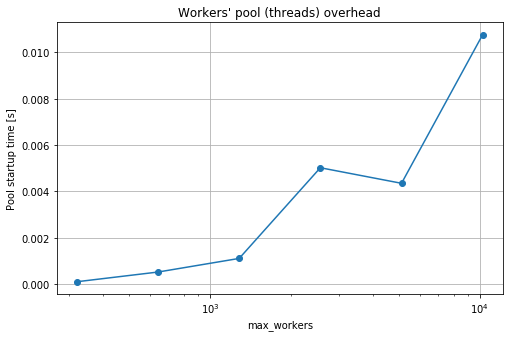

In [25]:
plt.plot(workers_numbers, th_startups, 'o-')
plt.title("Workers' pool (threads) overhead")
plt.xlabel("max_workers")
plt.ylabel("Pool startup time [s]")
plt.xscale('log')
plt.grid();